# Цель


Нужно получить модель, которая предскажет коэффициент восстановления золота из золотосодержащей руды. В распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

# 1. Подготовка данных

In [2]:
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')
print(df_train.info())
df_train.head()
print(df_test.info())
df_test.head()
print(df_full.info())
df_full.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

In [3]:
df_train_dropna = df_train.dropna()

C = df_train_dropna['rougher.output.concentrate_au']
F = df_train_dropna['rougher.input.feed_au']
T = df_train_dropna['rougher.output.tail_au']

ROR = (C * (F - T) * 100) / (F * (C - T))

I = df_train_dropna['rougher.output.recovery']
MAE = mean_absolute_error(I, ROR)

print("MAE:", MAE)

MAE: 1.1015161834408401e-14


### Вывод:

MAE стремится к нулю. Эффективность обогащения рассчитана правильно.

1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [4]:
print(df_test.columns)
print(df_full.columns)

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

### Вывод: 

Очевидно), в названиях столбцов тестовой выборки отсутствуют такие термины как: 'final', 'output', 'calculation'. Соответственно в тестовой выборке не представлены расчётные и выходные параметры, что логично для тестовой выборки.

1.4. Проведите предобработку данных.

In [5]:
print("Количество дубликатов:", df_full.duplicated().sum())

Количество дубликатов: 0


In [6]:
df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')
df_full = df_full.fillna(method='ffill')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22716 non-null float64
final.output.concentrate_pb                           22716 non-null float64
final.output.concentrate_sol                          22716 non-null float64
final.output.concentrate_au                           22716 non-null float64
final.output.recovery                                 22716 non-null float64
final.output.tail_ag                                  22716 non-null float64
final.output.tail_pb                                  22716 non-null float64
final.output.tail_sol                                 22716 non-null float64
final.output.tail_au                                  22716 non-null float64
primary_cleaner.input.sulfate                         22716 non-null float64
primary_cleaner.input.depressant             

### Вывод:

Все пропуски заполнены на "верхнее" значение.

# 2. Анализ данных

2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

In [8]:
list_au = []
for query in df_full.columns.tolist():
    if 'au' in query:
        list_au.append(query)
MED_au = df_full[list_au].median()
MED_au

final.output.concentrate_au                              44.639019
final.output.tail_au                                      2.910336
primary_cleaner.output.concentrate_au                    32.345542
primary_cleaner.output.tail_au                            3.509141
rougher.calculation.sulfate_to_au_concentrate         44061.596105
rougher.calculation.floatbank10_sulfate_to_au_feed     2940.838046
rougher.calculation.floatbank11_sulfate_to_au_feed     2897.014497
rougher.calculation.au_pb_ratio                           2.280603
rougher.input.feed_au                                     7.879193
rougher.output.concentrate_au                            19.995513
rougher.output.tail_au                                    1.826631
secondary_cleaner.output.tail_au                          3.950543
dtype: float64

In [9]:
list_ag = []
for query in df_full.columns.tolist():
    if 'ag' in query:
        list_ag.append(query)
MED_ag = df_full[list_ag].median()
MED_ag

final.output.concentrate_ag               4.949959
final.output.tail_ag                      9.477554
primary_cleaner.output.concentrate_ag     8.256062
primary_cleaner.output.tail_ag           15.592513
rougher.input.feed_ag                     8.295898
rougher.output.concentrate_ag            11.774115
rougher.output.tail_ag                    5.737042
secondary_cleaner.output.tail_ag         15.206375
dtype: float64

In [10]:
list_pb = []
for query in df_full.columns.tolist():
    if 'pb' in query:
        list_pb.append(query)
MED_pb = df_full[list_pb].median()
MED_pb

final.output.concentrate_pb              9.910363
final.output.tail_pb                     2.643964
primary_cleaner.output.concentrate_pb    9.882876
primary_cleaner.output.tail_pb           3.149221
rougher.calculation.au_pb_ratio          2.280603
rougher.input.feed_pb                    3.419915
rougher.output.concentrate_pb            7.570890
rougher.output.tail_pb                   0.589703
secondary_cleaner.output.tail_pb         5.061211
dtype: float64

### Вывод:

 От первой до финальной стадии присутствие золота в концентрате растёт, как и свинца (но не так резко). Концентрация серебра на начальном этапе растёт (по всей видимости первые этапы очистки связаны со схожими свойствами золота и серебра), на финальном этапе присутствие серебра в концентрате падает (соответственно финальный этап очистки скорее всего связан со свойствами, которыми эти два металла резко отличаются).

2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

In [11]:
feed_size_train = []
for query in df_train.columns.tolist():
    if 'feed_size' in query:
        feed_size_train.append(query)
MED_train = df_train[feed_size_train].describe()
MED_train

,primary_cleaner.input.feed_size,rougher.input.feed_size
count,16860.000000,16860.000000
mean,7.297285,60.188595
std,0.619166,30.522242
min,1.080000,9.659576
25%,6.940000,47.548897
50%,7.285000,54.066003
75%,7.700000,65.397249
max,10.470000,484.967466


In [12]:
feed_size_test = []
for query in df_test.columns.tolist():
    if 'feed_size' in query:
        feed_size_test.append(query)
MED_test = df_test[feed_size_test].describe()
MED_test

,primary_cleaner.input.feed_size,rougher.input.feed_size
count,5856.000000,5856.000000
mean,7.264651,55.898866
std,0.611526,22.707969
min,5.650000,0.046369
25%,6.885625,43.852884
50%,7.259333,49.964796
75%,7.650000,61.628003
max,15.500000,477.445473


### Вывод:

 Разница меньше 10 процентов. На оценку модели не сильно повлияет.

2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

In [14]:
df_train['sum_conc_input'] = (df_train['rougher.input.feed_au'] + df_train['rougher.input.feed_ag'] 
                              + df_train['rougher.input.feed_pb'])

df_train['sum_conc_rougher'] = (df_train['rougher.output.concentrate_au'] 
                                + df_train['rougher.output.concentrate_ag'] 
                                + df_train['rougher.output.concentrate_pb'])

df_train['sum_conc_final'] = (df_train['final.output.concentrate_au'] 
                              + df_train['final.output.concentrate_ag'] 
                              + df_train['final.output.concentrate_pb'])

df_test['sum_conc_input'] = (df_test['rougher.input.feed_au'] + df_test['rougher.input.feed_ag'] 
                             + df_test['rougher.input.feed_pb'])

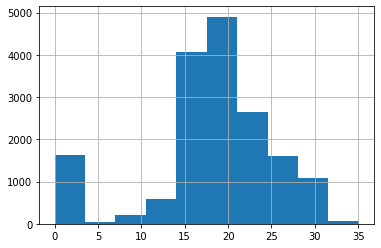

In [15]:
df_train['sum_conc_input'].hist()

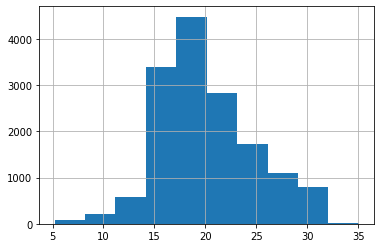

In [16]:
df_train = df_train.query('sum_conc_input > 5')
df_train['sum_conc_input'].hist()

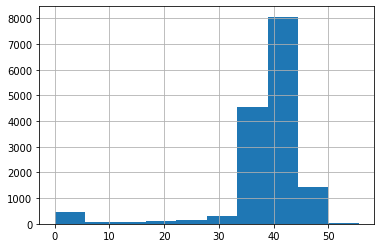

In [17]:
df_train['sum_conc_rougher'].hist()

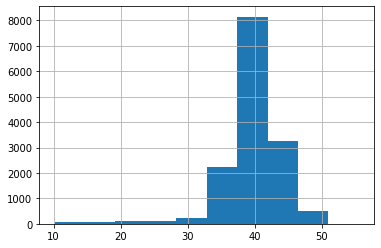

In [18]:
df_train = df_train.query('sum_conc_rougher > 10')
df_train['sum_conc_rougher'].hist()

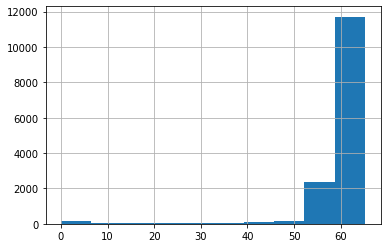

In [19]:
df_train['sum_conc_final'].hist()

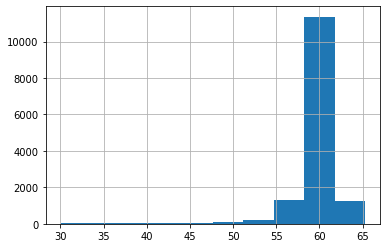

In [20]:
df_train = df_train.query('sum_conc_final > 30')
df_train['sum_conc_final'].hist()

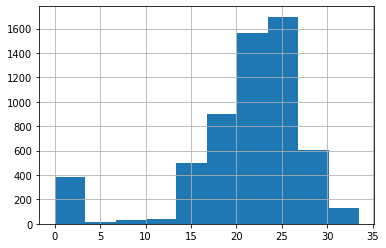

In [21]:
df_test['sum_conc_input'].hist()

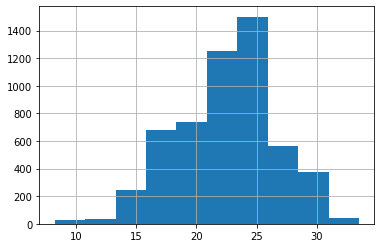

In [22]:
df_test = df_test.query('sum_conc_input > 8')
df_test['sum_conc_input'].hist()

### Вывод:

Проведена обрезка аномалий, которые плохо вписываются в нормальное распределение.

# 3. Модель

3.1. Напишите функцию для вычисления итоговой sMAPE.

In [24]:
def smape(y_true, y_pred):
    
    sMAPE = ((((abs(y_true - y_pred)) * 200)/(abs(y_true) + abs(y_pred))).sum()) / len(y_true)
    
    return sMAPE

smape_score = make_scorer(smape, greater_is_better = False) 

3.2. Обучите разные модели и оцените их качество кросс-валидацией.

Нужно спрогнозировать сразу две величины:
- эффективность обогащения чернового концентрата rougher.output.recovery;
- эффективность обогащения финального концентрата final.output.recovery.

In [25]:
features1 = df_train[df_test.columns].drop('date', axis=1)
target1 = df_train['rougher.output.recovery']
target2 = df_train['final.output.recovery']

In [26]:
model = DecisionTreeRegressor(random_state=12345, max_depth=3)
cross_val = cross_val_score(model, features1, target1, scoring = smape_score, cv=10)
final_score1 = cross_val.mean()
cross_val = cross_val_score(model, features1, target2, scoring = smape_score, cv=10)
final_score2 = cross_val.mean()
final_score = 0.25 * final_score1 + 0.75 * final_score2
print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: -9.828951354617288


In [27]:
model = RandomForestRegressor(random_state=12345, n_estimators=8, max_depth=10)
cross_val = cross_val_score(model, features1, target1, scoring = smape_score, cv=10)
final_score1 = cross_val.mean()
cross_val = cross_val_score(model, features1, target2, scoring = smape_score, cv=10)
final_score2 = cross_val.mean()
final_score = 0.25 * final_score1 + 0.75 * final_score2
print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: -9.880281137976139


In [28]:
model = LinearRegression()
cross_val = cross_val_score(model, features1, target1, scoring = smape_score, cv=10)
final_score1 = cross_val.mean()
cross_val = cross_val_score(model, features1, target2, scoring = smape_score, cv=10)
final_score2 = cross_val.mean()
final_score = 0.25 * final_score1 + 0.75 * final_score2
print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: -10.113339904283517


 Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

In [29]:
df_test.set_index("date", inplace = True)
df_full.set_index("date", inplace = True)

In [30]:
features = df_test
target_test_1 = pd.Series(df_full['rougher.output.recovery'], index=df_test.index)
target_test_2 = pd.Series(df_full['final.output.recovery'], index=df_test.index)

In [31]:
model = LinearRegression()

cross_val = cross_val_score(model, features, target_test_1, scoring = smape_score, cv=10)
final_score1 = cross_val.mean()

cross_val = cross_val_score(model, features, target_test_2, scoring = smape_score, cv=10)
final_score2 = cross_val.mean()

final_score = 0.25 * final_score1 + 0.75 * final_score2
print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: -11.524230741561444


### Вывод: 

LinearRegression() демонстрирует самое приемлемое значение метрики.